# Health Risk Prediction

Fall 2025 Data Science Project

Abhinav Akenapalli, Nathan James, Laila Shakoor, Amy Tan

### Contributions
Abhinav Akenapalli (C, E): Abhinav contributed to the data exploration by conducting an ANOVA test on the Risk Levels and Respiratory Rate attributes, as well as a Tukey post-hoc test. He also trained the algorithm.  
Nathan James (C, F): Nathan contributed to the data exploration by conducting a t-test on oxygen saturation. He also created a plot to visualize the results of the primary analysis.   
Laila Shakoor (C, G): Laila contributed to the data exploration by completing a z-test to determine if there were outliers. She also compiled everything and wrote explanations to create the final report.  
Amy Tan (A, B, D): Amy came up with the project idea, curated and preprocessed the data, and prepared the feature dataset for training.  

## Introduction

In this project, we will be training a Classification Algorithm to predict if a patient is has a low, medium, or high health risk level based on a variety of features. We will be answering a couple different questions. 

1. Can we accurately predict a patient's health risk level using the attributes in this dataset? 
2. Which features are most important when predicting health risk level?

Answering these questions will help us determine if health risk level prediction is possible, and if so, which factors should be more closely monitored in patients. Healthcare workers are busy and often have to keep up with a large number of patients and large volumes of data. With this information, healthcare workers can determine which information they should be devoting the most time and energy to monitoring.  

The model itself could help healthcare workers catch high-rish patients earlier, allowing for more preventative care and better medical decision making. 

This information could also be used in a nonprofessional setting. Many of us already track our health data, but oftentimes this data can be overwhelming when we don't know what actually matters or what to pay attention to. With this information, we could have a better sense of which measures of health data actually impact our health risk level, and pay more attention to those. 

## Data Curation and Preprocessing

### The Dataset

This dataset contains real-world patient health data. It provides vital signs and clinical parameters for 1,000 patents, along with their corresponding health risk levels. 

In [87]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import shap

### Data Curation

First, we imported the dataset and took a first glance at it. 

In [41]:
df = pd.read_csv("health-risk-prediction-anonymized-real-data/Health_Risk_Dataset.csv")
df.head()

,Patient_ID,Respiratory_Rate,Oxygen_Saturation,O2_Scale,Systolic_BP,Heart_Rate,Temperature,Consciousness,On_Oxygen,Risk_Level
0,P0522,25,96,1,97,107,37.5,A,0,Medium
1,P0738,28,92,2,116,151,38.5,P,1,High
2,P0741,29,91,1,79,135,38.4,A,0,High
3,P0661,24,96,1,95,92,37.3,A,0,Medium
4,P0412,20,96,1,97,97,37.4,A,0,Low


Then, we used the info function to learn more about the dataset. 

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Patient_ID         1000 non-null   object 
 1   Respiratory_Rate   1000 non-null   int64  
 2   Oxygen_Saturation  1000 non-null   int64  
 3   O2_Scale           1000 non-null   int64  
 4   Systolic_BP        1000 non-null   int64  
 5   Heart_Rate         1000 non-null   int64  
 6   Temperature        1000 non-null   float64
 7   Consciousness      1000 non-null   object 
 8   On_Oxygen          1000 non-null   int64  
 9   Risk_Level         1000 non-null   object 
dtypes: float64(1), int64(6), object(3)
memory usage: 78.3+ KB


From this, we learnedd that there are 1000 entries, as well as the names and data types of the attributes. Luckily, all attributes have the same number of entries, and there are no null entries. This is helpful because we will not have to deal with missing data. 

Then, using the describe function, we can see some summary statistics about the dataset. 

In [43]:
df.describe()

,Respiratory_Rate,Oxygen_Saturation,O2_Scale,Systolic_BP,Heart_Rate,Temperature,On_Oxygen
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,21.511000,92.59000,1.124000,106.160000,98.460000,37.921000,0.274000
std,5.287517,4.47302,0.329746,17.897562,19.694626,1.113696,0.446232
min,12.000000,74.00000,1.000000,50.000000,60.000000,35.600000,0.000000
25%,17.000000,90.00000,1.000000,94.000000,84.000000,37.100000,0.000000
50%,20.000000,94.00000,1.000000,109.000000,95.500000,37.800000,0.000000
75%,25.000000,96.00000,1.000000,119.000000,109.000000,38.600000,1.000000
max,40.000000,100.00000,2.000000,146.000000,163.000000,41.800000,1.000000


### Data Preprocessing

In order to work with the data, we need to do some preprocessing. Specifically, we need to convert some of the attribute data types so they are easier to work with once we begin building our model. Patient_ID needs to be converted to a string, since it is currently an object, and Consciousness, On_Oxygen, and Risk_Level need to be converted to category data types so they can be easily identified, instead of having to figure out what the string or integer means each time. 

In [44]:
# Pre-processing: Converting PatientID to String; Consciousness, On_Oxygen, and Risk_Level to category
df["Patient_ID"] = df["Patient_ID"].astype("string")
df["O2_Scale"] = df["O2_Scale"].astype("category")
df["Consciousness"] = df["Consciousness"].astype("category")
df["On_Oxygen"] = df["On_Oxygen"].astype("category")
df["Risk_Level"] = df["Risk_Level"].astype("category")
# Dropping any nan values
df = df.dropna(how='any')

## Exploratory Data Analysis

Before beginning developing our mode, we did some exploratory data analysis to learn more about the dataset. Specifically, we performed a z-test to determine if there were any outliers, a t-test to learn if being on supplemental oxygen significantly impacts a patient's oxygen saturation, and an ANOVA to determine if there was a difference in respiratory rates in each risk level category. We'll walk through each of those tests below. 

### Z-Test for Outliers

**Question: Are there extreme outliers (z-score greater than 3) in the continuous features of our Health Risk Prediction dataset?**

In order to determine if there were outliers, we ran a z-test which determines the z-score of each value and classifies it as an outlier if that z-score is greater than 3. 

In [45]:
continuous_features = ['Respiratory_Rate', 'Oxygen_Saturation', 'Systolic_BP',
            'Heart_Rate', 'Temperature']

for col in continuous_features:
    z = (df[col] - df[col].mean()) / df[col].std()
    df[f'{col}_Z'] = z
    outliers = df[np.abs(z) > 3]
    print(f"\n{col}: {len(outliers)} outliers")


Respiratory_Rate: 2 outliers

Oxygen_Saturation: 8 outliers

Systolic_BP: 2 outliers

Heart_Rate: 4 outliers

Temperature: 6 outliers


#### Visualization

We used a boxplot to visualize outliers. The outliers are shown as red points on the graph. 

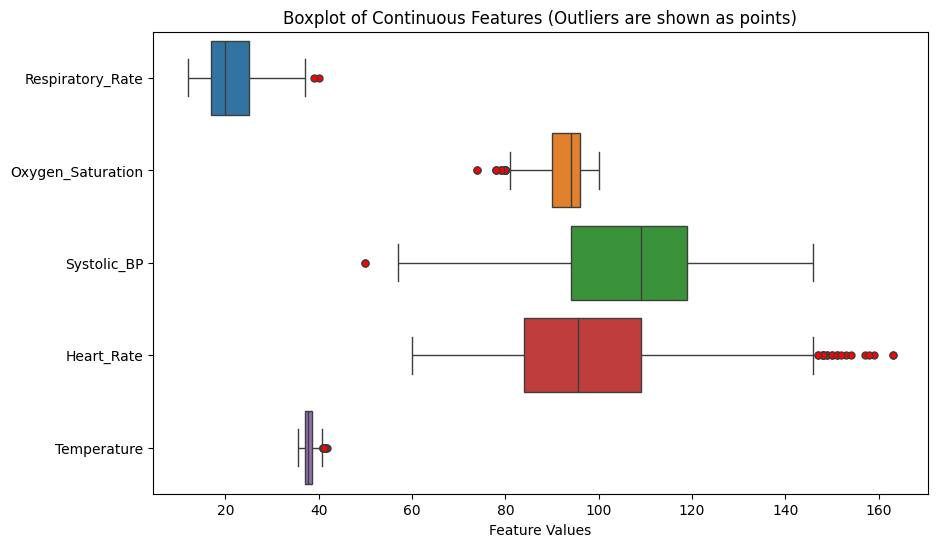

In [46]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[continuous_features], orient='h', flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'red'})
plt.title("Boxplot of Continuous Features (Outliers are shown as points)")
plt.xlabel("Feature Values")
plt.show()

#### Conclusion

There are 2-8 outliers (z-score greater than 3) in each continuous column of the dataset. 

### T-Test for Oxygen Saturation

**Research Question: Does being on supplemental oxygen ("On_Oxygen") significantly affect patients' mean oxygen saturation?**

**Groups:**
- Group 1 (0): Not on oxygen
- Group 2 (1): On oxygen
  
**Variable**: Oxygen_Saturation

#### Hypotheses

- **Null Hypothesis**: There is no difference in mean oxygen saturation between patients on oxygen vs. those not on oxygen.
- **Alternative Hypothesis**: Being on supplemental oxygen changes the mean oxygen saturation between the two groups.
This is a two-sample, two-tailed t-test.

#### Assumptions

- Independence: Each patient is unique.
- Normality: With n approximately 1000, CLT supports near-normal mean distribution.

T-statistic = -11.896, p-value = 0.000000000000000000000000000421


<Axes: xlabel='On_Oxygen', ylabel='Oxygen_Saturation'>

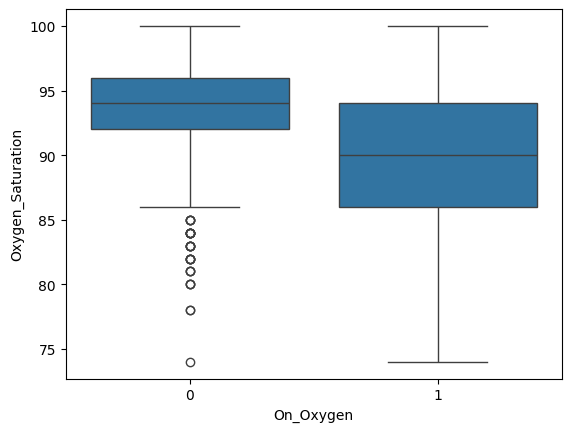

In [47]:
df = pd.read_csv("health-risk-prediction-anonymized-real-data/Health_Risk_Dataset.csv")

group_on = df[df['On_Oxygen'] == 1]['Oxygen_Saturation']
group_off = df[df['On_Oxygen'] == 0]['Oxygen_Saturation']

t_stat, p_val = stats.ttest_ind(group_on, group_off, equal_var=False)

print(f"T-statistic = {t_stat:.3f}, p-value = {p_val:.30f}")

sns.boxplot(x="On_Oxygen", y="Oxygen_Saturation", data=df)

#### Conclusion

Since p < 0.005: We reject the Null Hypothesis. Thus, there is a difference in mean oxygen saturation between patients on oxygen vs. those not on oxygen.

Note: There were multiple outliers found in the non-oxygenated group, with many of them having uncommonly high oxygen saturations pre-oxygen therapy.

### ANOVA Test for Respiratory Rate On Risk Level

**Question**:
Is there a difference in the respiratory rates in each risk category?

**Null Hypothesis**:
There is no difference in respiratory rates between risk categories.

**Alternate Hypothesis**:
There is a statisically significant difference in respiratory rates among risk categories.

In [48]:
groups = df.groupby("Risk_Level")
new_groups = [group["Respiratory_Rate"].values for name, group in groups]
f_stat, p_val = stats.f_oneway(*new_groups)
print(f"ANOVA F-statistic: {f_stat}, p-value: {p_val}")

ANOVA F-statistic: 724.3706495626732, p-value: 9.680624282636591e-250


#### Post-Hoc Analysis

In [49]:
tukey = pairwise_tukeyhsd(endog=df["Respiratory_Rate"], groups=df["Risk_Level"], alpha=0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
  High    Low  -9.5003   0.0 -10.1621  -8.8384   True
  High Medium   -7.031   0.0  -7.6634  -6.3986   True
  High Normal -12.0804   0.0  -12.838 -11.3228   True
   Low Medium   2.4693   0.0   1.8215    3.117   True
   Low Normal  -2.5801   0.0  -3.3506  -1.8097   True
Medium Normal  -5.0494   0.0  -5.7947  -4.3041   True
-----------------------------------------------------


#### Visualization

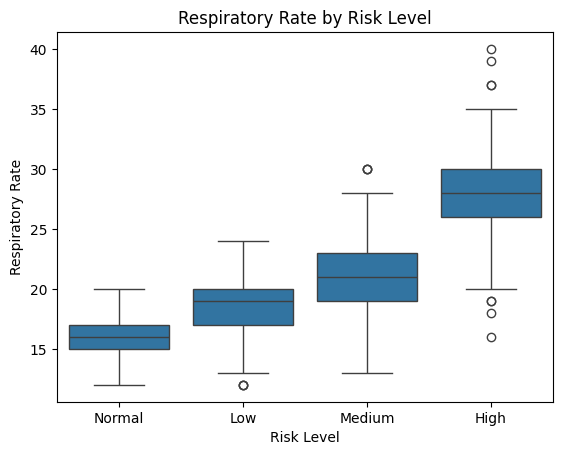

In [50]:
sns.boxplot(x="Risk_Level", y="Respiratory_Rate", data=df, order=["Normal", "Low", "Medium", "High"])
plt.xlabel("Risk Level")
plt.ylabel("Respiratory Rate")
plt.title("Respiratory Rate by Risk Level")
plt.show()

#### Conclusion

After running a one-way ANOVA on respiratory rates against risk levels, it was found that at least one mean is statistically different among the groups with a p-value less than 0.05. To further investigate this, a post hoc Tukey's HSD was run and determined a relationship such that respiratory rates increase in the following order: normal, low, medium, high. This indicates that each level increase like low to medium, corresponds with an increase in respiratory rate. The data contains outliers with the low, medium, and high levels. However, the data still trends in the direction that an increase in respiratory rate corresponds with an increase in risk level.

## Primary Analysis

### Choosing a Machine Learning Technique

We chose to develop a **classifier** to predict health risk level for two reasons.  

First, since health risk level is an attribute in the dataset, we would be able to easily test our model to determine its accuracy.   

And second, the potential impact of a project like this is huge. If healthcare workers are able to predict high risk patients early on, it could prevent future illnesses or complications. 

#### Feature Engineering 

##### Label Encoding 
We want to convert discrete values to some random number. We can do this with label encoding, which assigns a unique integer to each category.

In [51]:
encoder  = LabelEncoder()
df['Consciousness'] = encoder.fit_transform(df['Consciousness'])

##### Feature Importance Using Random Forest
Some features have a more significant impact on the final prediction than other features do. In order to limit dimensionality, we want to make sure that we're selecting our most influential and useful features. Here, we can use the random forest classifier's feature importance attribute to rank our features by importance. In this case, feature importance is measured by mean decrease in impurity (MDI).

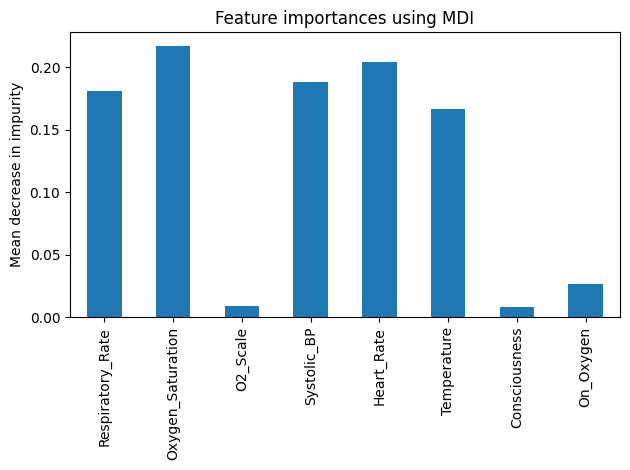

In [52]:
# Dropping Patient ID because it is used for identification purposes only
# Dropping Risk Level because it is what we want to predict 
X = df.drop(columns=["Risk_Level", "Patient_ID"])
y = df["Risk_Level"]

model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X, y)

# Extracting feature importances 
importances = model.feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names)

# Plotting
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

We can see that oxygen saturation, heart rate, systolic bp, respiratory rate, and temperature are our most significant features. However, since we don't have that many features in this particulat dataset, we elected to use all the vital statistics when training our classifier. 

### Training and Test Data Analysis

In [53]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

split predictors and outcome

In [54]:
X = df[continuous_features]
y = df["Risk_Level"]

train and test split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scale data

In [56]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train model

In [57]:
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


predict

In [58]:
y_pred = model.predict(X_test)

evaluate

In [59]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.98      0.99        56
         Low       0.94      0.90      0.92        51
      Medium       0.91      0.97      0.94        61
      Normal       1.00      0.97      0.98        32

    accuracy                           0.95       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.95      0.96       200

Accuracy: 0.9550


## Visualization

initializing SHAP explainer

In [82]:
kept_features = np.argsort(model.feature_importances_)[::-1][:4]
shap_feature_names = [continuous_features[i] for i in kept_features]
X_shap = pd.DataFrame(X_train[:, kept_features], columns=shap_feature_names)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap, check_additivity=False)

SHAP decision plot for feature contribution

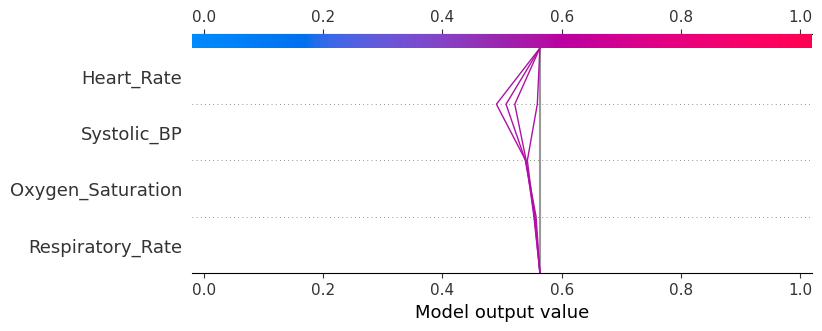

In [83]:
plt.figure(figsize=(12,6))
shap.decision_plot(
    explainer.expected_value[1],
    shap_values[1],
    X_shap,
    feature_names=shap_feature_names,
    link='logit'
)
plt.show()

confusion matrix

<function matplotlib.pyplot.show(close=None, block=None)>

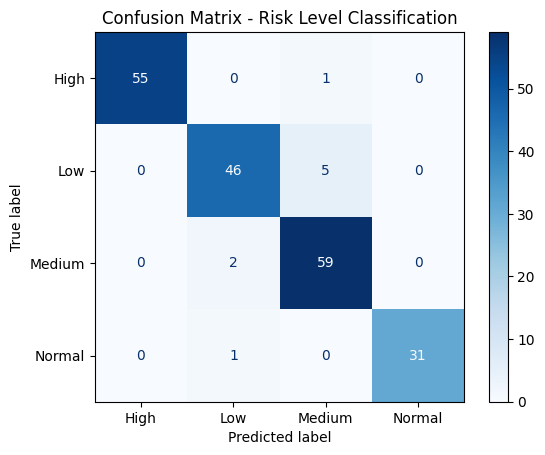

In [86]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Risk Level Classification")
plt.show

classification report heatmap

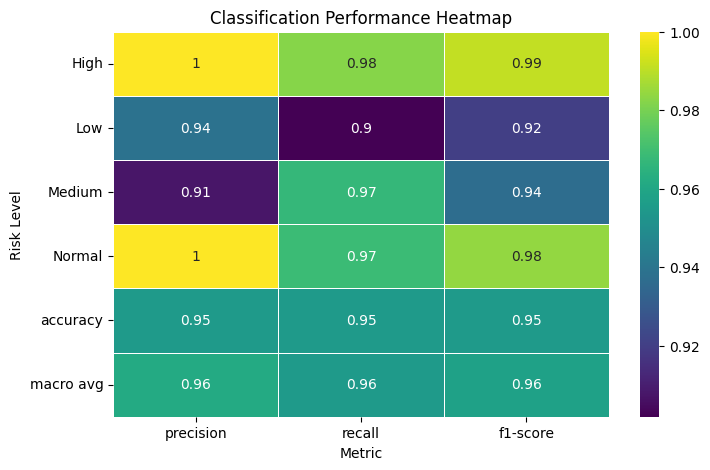

In [88]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).T.iloc[:-1, :3]

plt.figure(figsize=(8,5))
sns.heatmap(df_report, annot=True, cmap="viridis", linewidths=.5)
plt.title("Classification Performance Heatmap")
plt.xlabel("Metric")
plt.ylabel("Risk Level")
plt.show()

## Insights and Conclusions